# Example for running dobby

Dobby is a free ELF (emission line fitter). Dobby is distributed as a part of pycasso2 at https://bitbucket.org/streeto/pycasso2/.

Input:
- Nebular residual spectrum, i.e., observed minus stellar continuum spectrum.
- Error/uncertainty spectrum.
- Stellar continuum model (to measure equivalent widths more accurately.
- Optional, but highly recommended if turning on kinematic ties: instrumental dispersion spectrum.

References:
- Florido, 2018, MsC Thesis, Universidade Federal de Santa Catarina.
- Vale Asari et al., 2019, MNRAS, 489, 4721.

In [29]:
# Import libraries

# System and log
from os import path, makedirs
from astropy import log

# In/out & maths
import numpy as np
from astropy.table import Table

# Plots
%matplotlib inline
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = 'stix'
import matplotlib.pyplot as plt
from matplotlib import gridspec

# For spec reading & preprocessing
from astropy.io import fits
from pycasso2.starlight.io import read_output_tables_v4
from pycasso2.resampling import resample_cube
from pycasso2.resampling import vac2air

# For dobby
from pycasso2.dobby.fitting import fit_strong_lines
from pycasso2.dobby.utils import plot_el, read_summary_from_file, safe_div

log.setLevel('INFO')

In [2]:
## Reading an example spectrum

gal_id = '0480.51989.341'

# Read original observed SDSS spec -- flux uncertainties come from here, not from STARLIGHT!
cxt_file = 'dobby_example_in/%s.7xt' % gal_id
c = Table.read(cxt_file, format='ascii', names=['lambda', 'flux', 'error', 'flag'])
        
# Read STARLIGHT fits
fits_suffix = '7xt.sc5.C11.im.BS'
fits_file = 'dobby_example_in/%s.%s' % (gal_id, fits_suffix)
f = read_output_tables_v4(fits_file)

# Get synthetic spectrum
l_syn = f['spectra']['l_obs']
f_syn = f['spectra']['f_syn'] * f['keywords']['fobs_norm']

# !!! WARNING !!!!
# Do not use f_wei = 1 / f_err = f['spectra']['f_wei'] from STARLIHGHT.
# This should be, but the emission lines are masked out.
# If you use this in dobby, it will never fit any strong line.

# Resample all spectra to the same wavelength bins as the synthetic spectra
l_obs   = c['lambda']
_f_obs  = c['flux']
_f_err  = c['error']
_f_flag = c['flag']

f_obs  = resample_cube(l_obs, l_syn, _f_obs)
f_err  = resample_cube(l_obs, l_syn, _f_err)
f_flag = resample_cube(l_obs, l_syn, _f_flag)

# Calc residual spectrum
f_res = f_obs - f_syn

# Mask flagged pixels
f_res[f_flag > 1] = np.ma.masked

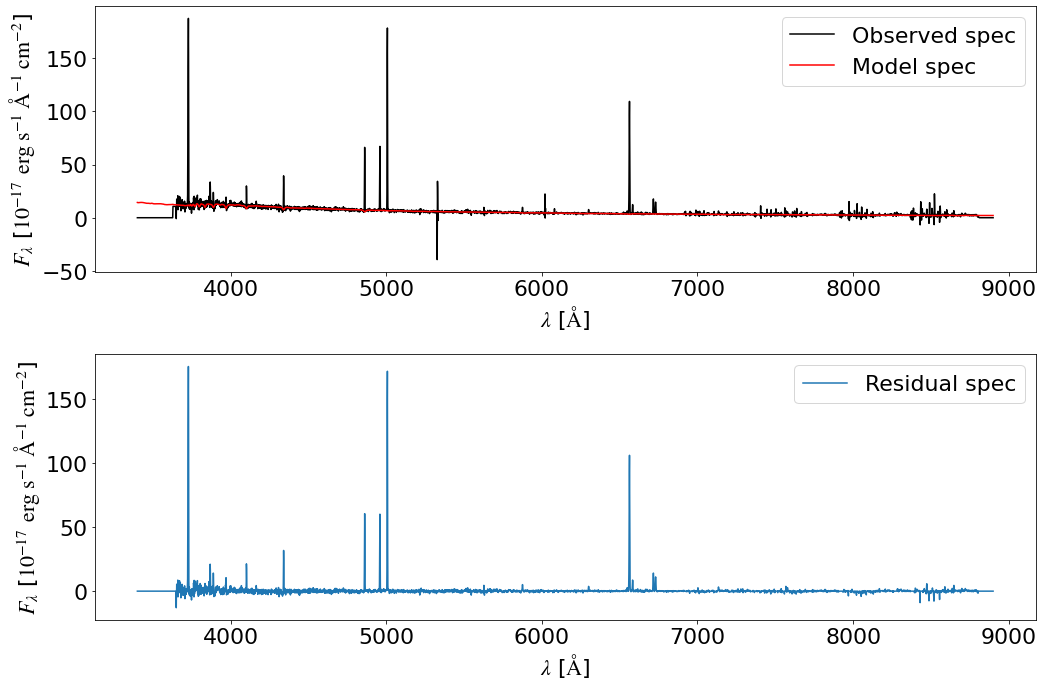

In [3]:
# Check spectra

fig = plt.figure(figsize=(15, 10))
plt.clf()
plt.rcParams.update({'font.size': 22})

gs1 = gridspec.GridSpec(2, 1)
    
ax = plt.subplot(gs1[0, 0])
plt.plot(l_syn, f_obs, 'k', label='Observed spec')
plt.plot(l_syn, f_syn, 'r', label='Model spec')
plt.ylabel('$F_\lambda$ [$10^{-17}$ $\mathrm{erg \; s}^{-1} \; \mathrm{\AA}^{-1} \; \mathrm{cm}^{-2}$]')
plt.xlabel('$\lambda$ [$\mathrm{\AA}$]')
plt.legend()

ax = plt.subplot(gs1[1, 0])
plt.plot(l_syn, f_res, label='Residual spec')
plt.ylabel('$F_\lambda$ [$10^{-17}$ $\mathrm{erg \; s}^{-1} \; \mathrm{\AA}^{-1} \; \mathrm{cm}^{-2}$]')
plt.xlabel('$\lambda$ [$\mathrm{\AA}$]')
plt.legend()

fig.tight_layout()

In [4]:
# Get instrumental dispersion
# See: http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html#maskres

plate, mjd, fiber = gal_id.split('.')

# Read original SDSS fits file
# E.g. http://das.sdss.org/spectro/1d_26/0480/1d/spSpec-51989-0480-341.fit
sdss_name = 'spSpec-%s-%s-%s.fit' % (mjd, plate, fiber)
sdss_file = path.join('dobby_example_in', sdss_name)
if (not path.exists(sdss_file)):
    import urllib.request
    log.info('Downloading %s' % sdss_file)
    urllib.request.urlretrieve('http://das.sdss.org/spectro/1d_26/%s/1d/%s' % (plate, sdss_name), sdss_file)
s = fits.open(sdss_file)
flux = s[0].data[0]

# Get log wavelength
w0 = s[0].header['COEFF0']
dw = s[0].header['COEFF1']
w = np.linspace(w0, w0 + dw*(len(flux)-1), num=len(flux))

# Transform to lambda and from vacuum to air
ll = vac2air(10.**w)

# Restframe
redshift = s[0].header['Z']
z_plus_1 = 1.0 + redshift
flux *= z_plus_1
ll /= z_plus_1

# Get instrumental dispersion
disp = s[6].data['dispersion']

print(disp.shape, ll.shape, w.shape, flux.shape, w0, dw)

# Transform dispersion from pixel to wavelegth units
disp *= np.log(10.) * ll * dw

# Resample to the same wavelength bins as the synthetic spectra
f_disp  = resample_cube(ll, l_syn, disp) 

(3853,) (3853,) (3853,) (3853,) 3.5796 0.0001


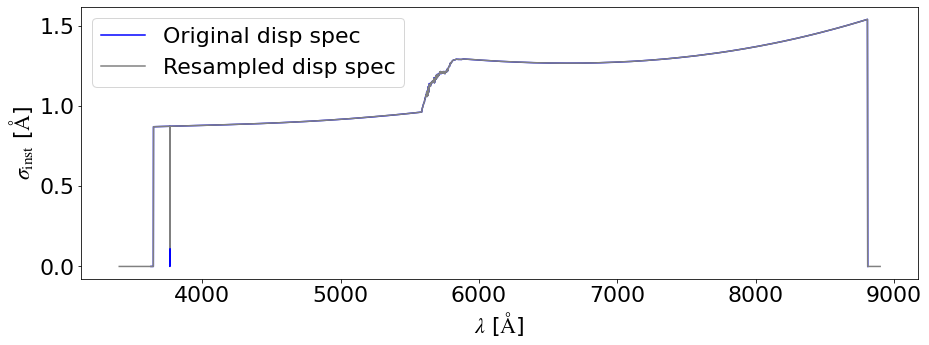

In [5]:
# Check instrumental dispersion

fig = plt.figure(figsize=(15, 5))
plt.clf()
plt.rcParams.update({'font.size': 22})

plt.plot(ll, disp, c='b', label='Original disp spec')
plt.plot(l_syn, f_disp, c='grey', label='Resampled disp spec')
plt.ylabel('$\sigma_\mathrm{inst}$ [$\mathrm{\AA}$]')
plt.xlabel('$\lambda$ [$\mathrm{\AA}$]')
plt.legend()

In [6]:
# Options for dobby

# Output dir for individual files
out_dir = 'dobby_example_out/'

# Overwrite output
overwrite = False

# Line profile model: gaussian or resampled_gaussian
model = 'gaussian'

# Enable kinematic ties between ions of the same species
enable_kin_ties = True

# Do not allow Ha/Hb < 2.6
enable_balmer_lim = True

# Degree for Legendre polynomial fits in the local pseudocontinuum
degree = 16

# Instrumental dispersion spectrum in km/s? (True = yes, False = in angstroms)
vd_kms = False

In [7]:
# Create output directory
if not path.exists(out_dir):
    log.info('Creating directory %s.' % out_dir)
    makedirs(out_dir)

# Create dobby output name
_k = 1 * enable_kin_ties
_b = 1 * enable_balmer_lim
if model == 'gaussian':
    _m = 'GA'
elif model == 'resampled_gaussian':
    _m = 'RG'
else:
    raise Exception('Unknown model: %s' % model)
suffix = 'El%sk%ib%i' % (_m, _k, _b)
outname = '%s%s.%s' % (gal_id, fits_suffix, suffix)
outfile = path.join(out_dir, '%s.hdf5' % outname)    

Using stellar v0 = 0.00, vd = 100.00 to mask out emission lines for the pseudocontinuum fit.


/usr/local/Anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:5322: RuntimeWarning: Degrees of freedom <= 0 for slice
  ddof=ddof, **kwargs)[()]
/usr/local/Anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/Anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


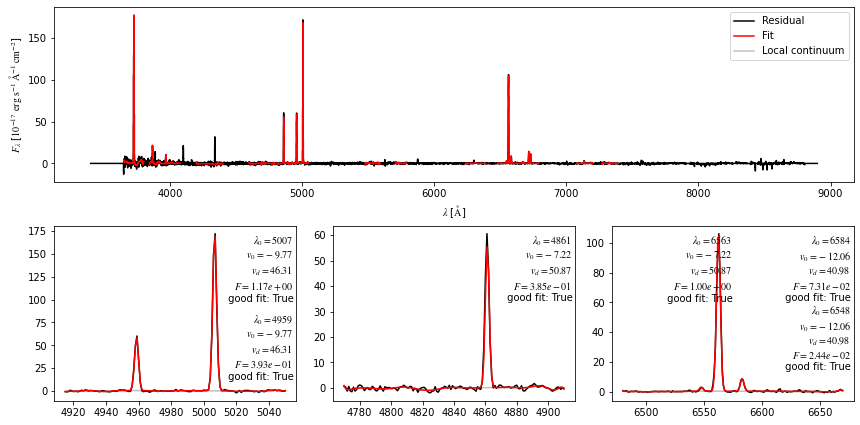

In [8]:
# Fit and save result with dobby
el = fit_strong_lines(l_syn, f_res, np.ma.array(f_syn), f_err, vd_inst = f_disp,
                      kinematic_ties_on = enable_kin_ties, balmer_limit_on = enable_balmer_lim, model = model,
                      saveAll = True, outname = outname, outdir = out_dir, overwrite = overwrite, degree=degree,
                      vd_kms = vd_kms)

# Also save fitted spectrum (optional, but good for debugging!)
plt.rcParams.update({'font.size': 10})
fig = plot_el(l_syn, f_res, el, display_plot = False)
fig.savefig( path.join(out_dir, '%s.pdf' % outname) )

# Dobby results

Below are the results from dobby. An emission line Gaussian profile (for the `gaussian' option) is given by

$$
G(\lambda) = \dfrac{F}{\sigma_\mathrm{obs} \sqrt{2\pi}} \; \exp\left[ -\dfrac{(v - v_0)^2}{2 \sigma_\mathrm{obs}^2}\right],
$$

where $F$ is the line flux, $\sigma_\mathrm{obs}$ is the total dispersion (i.e. the sum in quadrature of the instrumental dispersion, $\sigma_\mathrm{inst}$, and the intrinsic dispersion, $\sigma$). Velocities are transformed into wavelengths using the relation

$$
v = c \, \dfrac{\lambda - \lambda_0}{\lambda_0},
$$

where $\lambda_0$ is the restframe line centre.

This is the translation between the parameters above and the output table below:
- lambda: Emission line `lambda'; arbitrarily chosen.
- line: Line name.
- El_l0: Restframe line centre in air wavelengths ($\lambda_0$) in angstroms.
- El_F: Line flux ($F$) in the units of the original spectrum $\times$ Å.
- El_v0: Systemic velocity ($v_0$) in km/s.
- El_vd: Intrinsic line dispersion $\sigma$ in km/s (i.e. subtracting the instrumental dispersion in quadrature from the observed dispersion).
- El_flag: if $> 0$, the line was not fitted successfully.
- El_EW: line equivalent width in Å. The continuum value is taken from the median continua on side-bands and using a linear interpolation to measure the continuum at the line centre (see Table 1 from Vale Asari et al. 2019). We suggest this is measured in the noise-free model continuum spectrum.
- El_lcrms: rms in the detrended residual continua in the two windows bluewards and redwards of the line.
- El_vdinst: Instrumental dispersion ($\sigma_\mathrm{inst}$) in km/s.

In [9]:
# Get dobby results

elines, pseudo_cont_spec = read_summary_from_file(outfile)

elines

lambda,line,El_l0,El_F,El_F_e,El_v0,El_v0_e,El_vd,El_vd_e,El_flag,El_EW,El_lcrms,El_vdins
int64,bytes11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
3726,[OII]3726,3726.032,332.22231070099195,3.226194963763491,-41.22166803741542,3.8957872369258615,60.74401396488014,4.229862482009158,0,28.105019815271927,3.1913222902116027,70.27548157990687
3729,[OII]3729,3728.815,498.2010990439554,3.7167362150935657,-41.22166803741542,3.8957872369258615,60.74401396488014,4.229862482009158,0,42.12496238262806,3.1913222902116027,70.2285655165041
4861,Hbeta,4861.33,172.91964962116012,-999.0,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,23.706089210384146,0.7954380195854582,56.110070635008846
4340,Hgamma,4340.464,81.74383436636661,-999.0,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,8.428528126019431,1.1487962335869017,61.39139070998987
4959,[OIII]4959,4958.911,176.60305753755202,0.3090984807046347,-9.76681056412293,0.5600041496002073,46.30794102409534,0.7558240518357656,0,25.789590781079838,0.69588196310942,55.3273609747851
5007,[OIII]5007,5006.843,524.5110808865295,0.9180224876927651,-9.76681056412293,0.5600041496002073,46.30794102409534,0.7558240518357656,0,78.96462488556521,0.69588196310942,54.965569903829916
4363,[OIII]4363,4363.21,6.765412326714044,1.3084574756156089,-9.76681056412293,0.8215448943133736,46.30794102409534,1.0261960791609945,0,0.7147841444401989,1.0435071702434775,61.11958327854561
4288,[FeII]4288,4287.5,0.842420931548325,1.3986625078981216,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,0.08349315925514296,1.0435071702434775,62.03957023586205
4360,[FeII]4360,4359.333,1.5810664030072088,1.3639586852463272,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,0.16648124682877147,1.0435071702434775,61.165758388044516


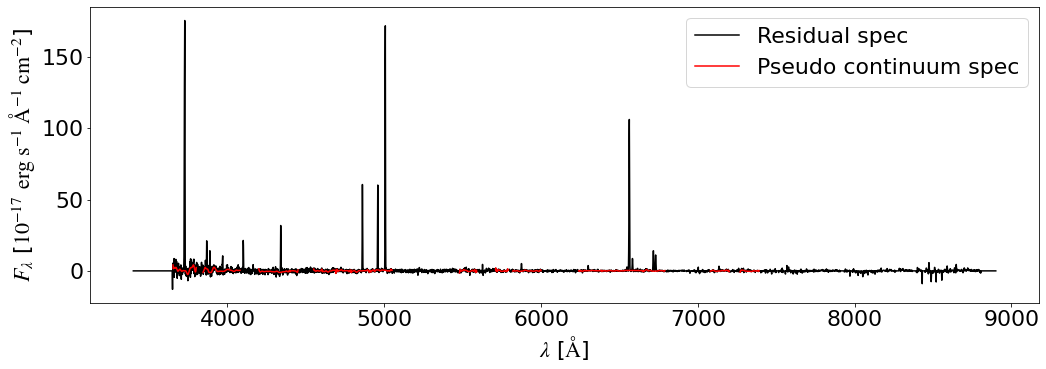

In [10]:
# Check spectra

f_lc = np.ma.array(pseudo_cont_spec['total_lc'], mask=pseudo_cont_spec['total_lc_mask'])

fig = plt.figure(figsize=(15, 10))
plt.clf()
plt.rcParams.update({'font.size': 22})

gs1 = gridspec.GridSpec(2, 1)
    
ax = plt.subplot(gs1[1, 0])
plt.plot(l_syn, f_res, 'k', label='Residual spec')
plt.plot(l_syn, f_lc, 'r', label='Pseudo continuum spec')
plt.ylabel('$F_\lambda$ [$10^{-17}$ $\mathrm{erg \; s}^{-1} \; \mathrm{\AA}^{-1} \; \mathrm{cm}^{-2}$]')
plt.xlabel('$\lambda$ [$\mathrm{\AA}$]')
plt.legend()

fig.tight_layout()

# Uncertainties in the flux

Uncertainties in line fluxes may be inferred using the [Rola & Pelat (1994)](http://adsabs.harvard.edu/abs/1994A%26A...287..676R) prescription:
$$
F_e = \sigma_N \sqrt{6 \sigma_\lambda \Delta\lambda},
$$
with $\sigma_N$ being the rms in the residual continuum contiguous to the
emission-line, $\sigma_\lambda$ the Gaussian dispersion in Å, and $\Delta\lambda = 1$ Å the spectral sampling. 

# Uncertainties in all parameters

Alternatively, one can run a Monte Carlo simulation by creating different versions of the input spectrum (assuming the error spectrum is Gaussian) and re-fitting the lines with dobby. This allows one to measure the uncertainties not only in line fluxes, but also in $v_0$ and $\sigma$. The implementation by Florido 2018 has never added to the repository, so we leave it as exercise for the user.

We have tried using LevMarLSQFitter(calc_uncertainties = False), which would give the formal uncertainties in the fitted parameters, but found it very unreliable thus far (Apr/2021).

In [38]:
from pycasso2.dobby.utils import get_el_info
import astropy.constants as const

# Speed of light
c_light = const.c.to('km/s').value

# Get error in flux, A/N and S/N for emission lines
for par in ['El_A', 'El_AN', 'El_eF', 'El_SN']:
    elines[par] = np.zeros_like(elines['El_F'])

for i, line in enumerate(elines['lambda']):
    F = get_el_info(elines, line, 'El_F')[0]
    l0 = get_el_info(elines, line, 'El_l0')[0]
    vd = get_el_info(elines, line, 'El_vd')[0]
    vdins = get_el_info(elines, line, 'El_vdins')[0]
    lcrms = get_el_info(elines, line, 'El_lcrms')[0]
    vdtot_ang = l0 * np.sqrt(vd**2 + vdins**2) / c_light
    A = safe_div(F, (np.sqrt(2. * np.pi) * vdtot_ang))
    dl = 1.
    eF = lcrms * np.sqrt(6. * vdtot_ang * dl)
    elines['El_A' ][i] = A
    elines['El_AN'][i] = safe_div(A, lcrms)
    elines['El_eF'][i] = eF
    elines['El_SN'][i] = safe_div(F, eF)            

print('eF(5007) = ' , get_el_info(elines, 5007, 'El_eF')[0])
print('S/N(5007) = ', get_el_info(elines, 5007, 'El_SN')[0])

# Also check new uncertainty info added to the elines table
elines

eF(5007) =  1.8675139700972887
S/N(5007) =  280.86059289784316


lambda,line,El_l0,El_F,El_F_e,El_v0,El_v0_e,El_vd,El_vd_e,El_flag,El_EW,El_lcrms,El_vdins,El_A,El_AN,El_eF,El_SN
int64,bytes11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
3726,[OII]3726,3726.032,332.22231070099195,3.226194963763491,-41.22166803741542,3.8957872369258615,60.74401396488014,4.229862482009158,0,28.105019815271927,3.1913222902116027,70.27548157990687,114.80105288270643,35.97287971660627,8.399294044525202,39.553599259635384
3729,[OII]3729,3728.815,498.2010990439554,3.7167362150935657,-41.22166803741542,3.8957872369258615,60.74401396488014,4.229862482009158,0,42.12496238262806,3.1913222902116027,70.2285655165041,172.0931003161489,53.92532770632143,8.400824944849768,59.30383055409146
4861,Hbeta,4861.33,172.91964962116012,-999.0,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,23.706089210384146,0.7954380195854582,56.110070635008846,56.1718489875546,70.61750583260843,2.159234530606971,80.08377374946463
4340,Hgamma,4340.464,81.74383436636661,-999.0,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,8.428528126019431,1.1487962335869017,61.39139070998987,28.251492887060767,24.592257583271103,3.0232945611079725,27.03799868459038
4959,[OIII]4959,4958.911,176.60305753755202,0.3090984807046347,-9.76681056412293,0.5600041496002073,46.30794102409534,0.7558240518357656,0,25.789590781079838,0.69588196310942,55.3273609747851,59.03501586403707,84.8348125021807,1.8621321788301453,94.83916316214463
5007,[OIII]5007,5006.843,524.5110808865295,0.9180224876927651,-9.76681056412293,0.5600041496002073,46.30794102409534,0.7558240518357656,0,78.96462488556521,0.69588196310942,54.965569903829916,174.32490016355882,250.5092952612541,1.8675139700972887,280.86059289784316
4363,[OIII]4363,4363.21,6.765412326714044,1.3084574756156089,-9.76681056412293,0.8215448943133736,46.30794102409534,1.0261960791609945,0,0.7147841444401989,1.0435071702434775,61.11958327854561,2.4184059032147625,2.3175747825963526,2.700278967647554,2.5054494027363323
4288,[FeII]4288,4287.5,0.842420931548325,1.3986625078981216,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,0.08349315925514296,1.0435071702434775,62.03957023586205,0.2929081914111991,0.2806959068070955,2.737946209780353,0.3076835215166286
4360,[FeII]4360,4359.333,1.5810664030072088,1.3639586852463272,-7.220595397730388,0.8215448943133736,50.86819608021253,1.0261960791609945,0,0.16648124682877147,1.0435071702434775,61.165758388044516,0.54525461008154,0.5225211916409906,2.749169250545785,0.575106971931002
